# Analysis Template
WIP new analysis template. Only to be used with most recent version of kinetics package as of 11/21/23.

In [ ]:
### PARAMETERS:
EGFP_SLOPE = 91900.03
EGFP_SLOPE_CONC_UNITS = 'nM' #RFU/nM


In [219]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import skimage
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from tqdm import tqdm 

from pathlib import Path 
from htbam_db_api.htbam_db_api import LocalHtbamDBAPI
from scipy.optimize import curve_fit

#Import Kinetics Package for line fitting:
import kinetics

#Configuration settings for pandas and seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='ticks', context='paper', font_scale=1.2, rc={"lines.linewidth": 1.2})

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.00679275651041185
0.008924463130828788


## 0. Helper Functions

In [ ]:
### Convert from DB to numpy arrays quickly:

def assay_data_to_array(db_obj, run_name):
    '''This function takes as input an HTBAM Database object.
    For each kinetics run, we have 
    It returns 3 numpy arrays:
    chamber_ids: an array of the chamber ids (in the format '1,1' ... '32,56')
        shape: (n_chambers,)
    luminance_data: an array of the luminance data for each chamber
        shape: (n_time_points, n_chambers, n_assays)
    conc_data: an array of the concentration data for each chamber.
        shape: (n_assays,)
    time_data: an array of the time data for each time point.
        shape: (n_time_points, n_assays)
    '''
    
    chamber_idxs = np.array(list(db_obj._json_dict['chamber_metadata'].keys()))
    luminance_data = None
    time_data = None
    conc_data = np.array([])

    #Each assay may have recorded a different # of time points.
    #First, we'll just check what the max # of time points is:
    max_time_points = 0
    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        current_assay_time_points = len(np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s']))
        if current_assay_time_points > max_time_points:
            max_time_points = current_assay_time_points

    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        
        #to make things easier later, we'll be sorting the datapoints by time value.
        #Get time data:
        #collect from DB
        current_time_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s'])
        current_time_array = current_time_array.astype(float) #so we can pad with NaNs
        #pad the array with NaNs if there are fewer time points than the max
        current_time_array = np.pad(current_time_array, (0, max_time_points - len(current_time_array)), 'constant', constant_values=np.nan)
        #sort, and capture sorting idxs:
        sorting_idxs = np.argsort(current_time_array)
        current_time_array = current_time_array[sorting_idxs]
        current_time_array = np.expand_dims(current_time_array, axis=1)
        #add to our dataset
        if time_data is None:
            time_data = current_time_array
        else:
            time_data = np.concatenate([time_data, current_time_array], axis=1)

        #Get luminance data:
        current_luminance_array = None
        for chamber_idx in chamber_idxs:
            #collect from DB
            current_chamber_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['chambers'][chamber_idx]['sum_chamber'])
            #set type to float:
            current_chamber_array = current_chamber_array.astype(float)
            #pad the array with NaNs if there are fewer time points than the max
            current_chamber_array = np.pad(current_chamber_array, (0, max_time_points - len(current_chamber_array)), 'constant', constant_values=np.nan)
            #sort by time:
            current_chamber_array = current_chamber_array[sorting_idxs]
            #add a dimension at the end:
            current_chamber_array = np.expand_dims(current_chamber_array, axis=1)

            if current_luminance_array is None:
                current_luminance_array = current_chamber_array
            else:
                current_luminance_array = np.concatenate([current_luminance_array, current_chamber_array], axis=1)
        #add a dimension at the end:
        current_luminance_array = np.expand_dims(current_luminance_array, axis=2)
        #add to our dataset
        if luminance_data is None:
            luminance_data = current_luminance_array
        else:
            luminance_data = np.concatenate([luminance_data, current_luminance_array], axis=2)
        
        #Get concentration data:
        #collect from DB
        current_conc = db_obj._json_dict["runs"][run_name]['assays'][assay]['conc']
        conc_data = np.append(conc_data, current_conc)

    #sort once more, by conc_data:
    sorting_idxs = np.argsort(conc_data)
    conc_data = conc_data[sorting_idxs]

    #sort luminance data by conc_data:
    luminance_data = luminance_data[:,:,sorting_idxs]
    
    return chamber_idxs, luminance_data, conc_data, time_data



In [ ]:
### Plot a chip using a given variable, with subplots:

def plot_chip(plotting_var, chamber_names, graphing_function=None, title=None):
    ''' This function creates a Dash visualization of a chip, based on a certain Run (run_name)
        Inputs:
            plotting_var: a dictionary mapping chamber_id to the variable to be plotted for that chamber
            chamber_names: a dictionary mapping chamber_id to the name of the sample in the chamber (e.g. '1,1': ecADK_XYZ')
            graphing_function: a function that takes in a single chamber_id (e.g. '1,1') and matplotlib axis and returns the axis object after plotting.
            title: a string to be used as the title of the plot
        TODO: make all the variables stored in Dash properly...
    '''
    from dash import Dash, dcc, html, Input, Output, no_update
    import plotly.graph_objs as go
    import base64
    import tempfile

    # Make the image array
    #NB: eventually, store width/height in DB and reference!
    img_array = np.zeros([56,32])

    for chamber_id, value in plotting_var.items():
        x = int(chamber_id.split(',')[0])
        y = int(chamber_id.split(',')[1])
        img_array[y-1,x-1] = value 
    
    #generate title
    if title is None:
        title = ''
    
    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    #center title in fig
    fig.update_layout(title=title,
                        title_x=0.5, 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = Dash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    ### GRAPHING FUNCTION ON HOVER:
    if graphing_function is not None:
        @app.callback(
            Output("graph-tooltip", "show"),
            Output("graph-tooltip", "bbox"),
            Output("graph-tooltip", "children"),
            Input("graph", "hoverData"),
        )
        def display_hover(hoverData):
            if hoverData is None:
                return False, no_update, no_update
            # demo only shows the first point, but other points may also be available
            pt = hoverData["points"][0]
            chamber_id = str(pt['x']+1) + ',' + str(pt['y']+1)
            bbox = pt["bbox"]
            chamber_name = chamber_names[chamber_id]
            #get the data for the point:
            fig, ax = plt.subplots()
            ax = graphing_function(chamber_id, ax)
            #reduce whitespace on margins of graph:
            fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
            #save the figure as a temp file:
            tempfile_name = tempfile.NamedTemporaryFile().name+'.png'
            plt.savefig(tempfile_name)
            plt.close()
            # #read in temp file as base64 encoded string:
            with open(tempfile_name, "rb") as image_file:
                img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
            children = [
                html.Div(children=[
                    #no space after header:
                    html.H3('{},{}:  {}'.format(pt['x'], pt['y'], chamber_name), style={"color": 'black', "fontFamily":"Arial", "textAlign": "center", "marginBottom": "0px"}),
                    #add the image with reduced whitespace:
                    html.Img(src=img_src, style={"width": "100%"}),
                ],
                style={'width': '400px', 'white-space': 'none'})
            ]

            return True, bbox, children

    app.run_server()

## 1. Connect DB Api

In [ ]:
#from htbam_analysis.htbam_db_api import LocalHtbamDBAPI

root = '/Users/duncanmuir/Desktop/20240501_nick_inhibition_fix/En-Flowon/'
db_conn = LocalHtbamDBAPI(standard_curve_data_path= root + 'd3_2_StandardSeries_Analysis.csv', standard_name="NADPH std curve", standard_type="NADPH", standard_units="uM",
                         kinetic_data_path= root+ 'd3_TitrationSeries_Analysis-noinhib.csv', kinetic_name="ADP kinetics curve", kinetic_type="ADP", kinetic_units="uM")

### TODO: Still want the following data in the database:
# date (and time?) collected
# operator name
# Add additional descriptors
# substrate_name
# setup(?) and device_num
# width/height


## 2. Standards

In [ ]:
#Here, we collect our data into numpy arrays
chamber_idxs, luminance_data, conc_data, _ = assay_data_to_array(db_conn, 'standard_0')

#shape should be (time x wells x assays) or (1, 1792, 7) in the example data (not true???)
print('Luminance data shape:', luminance_data.shape)

#Perform linear regression for each chamber:
#and store immediately in 'database' object
if 'analyses' not in db_conn._json_dict['runs']['standard_0'].keys():
    db_conn._json_dict['runs']['standard_0']['analyses'] = {}

db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression'] = {'chambers': {}} #initialize the dictionary
for i in range(len(chamber_idxs)):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(conc_data, luminance_data[:,i])
    db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idxs[i]] = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'r2':r_value**2, 'p_value': p_value, 'std_err': std_err}

### Sanity check:
Now, let's sanity check by plotting. We can use the ```plot_chip()``` function to show a chip where each chamber is colored by variable (like luminance). We can also make subplots on hover.

In [ ]:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
slopes_to_plot = {chamber_idx: db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs}

#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items()}

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_slopes(chamber_id, ax):
    #parameters:
    run_name = 'standard_0'
    analysis_name = 'linear_regression'
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)
    x_data = conc_data
    y_data = luminance_data[:,data_index]

    #get slope from the analysis:
    slope = np.array([db_conn._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])
    intercept = np.array([db_conn._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['intercept'] for chamber_idx in chamber_idxs])
    m = slope[data_index]
    b = intercept[data_index]
    #make a simple matplotlib plot
    ax.scatter(x_data, y_data)
    if not (np.isnan(m) or np.isnan(b)):
        #return False, no_update, no_update
        ax.plot(x_data, m*np.array(x_data) + b)
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(slopes_to_plot, chamber_names_dict, graphing_function=plot_chamber_slopes, title='Standard Curve: Slope')



## 7. Fit initial rates from processed kinetic data

For this next part, we'll be generating the predicted product concentration for each well, for each time, and for each substrate concentration. That's a 3D array.

To do this, we divide our luminance value (in RFUs) by the slope of the chamber's standard curve (RFU/conc). Here, we ignore the standard curve intercept.

In [ ]:
#Gather kinetics data into numpy arrays
chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'kinetics_0')
print('Luminance data shape:', luminance_data.shape) #(time x wells x assays)

Each well contains time_series data. We have 32*56 wells (1792), and then N assays with different concentrations.
So we have a np array with dimensions (time x wells x assays)
For a standard, this will be (1, 1792, # concentrations)
For a kinetics run, this will be (~20, 1792, # concentrations)

In [ ]:
slopes = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])

#calculate product concentration by dividing every chamber intensity by the slope of the standard curve for that chamber
product_concentration = luminance_data / slopes[np.newaxis, :, np.newaxis]


In [ ]:
#make numpy array of all button_quants with[ subtracted backgrounds:
button_quant_no_background = [] #we will soon turn this into a numpy array
for chamber_idx in chamber_idxs:
    next_button_quant = db_conn._json_dict['button_quant'][chamber_idx]['summed_button_BGsub_Button_Quant']
    button_quant_no_background.append(next_button_quant)
button_quant_no_background = np.array(button_quant_no_background)

# use eGFP standard curve to convert between button quant and eGFP concentration
enzyme_concentration = button_quant_no_background / EGFP_SLOPE    #in units of EGFP_SLOPE_CONC_UNITS
print('Enzyme concentration shape:', enzyme_concentration.shape)


### Fit initial rates

In [200]:
MAX_RXN_PERC = 15
STARTING_IDX = 1
MAX_RXN_TIME = 300

arr = np.empty((len(chamber_idxs), len(conc_data)))
arr[:] = np.nan
    
#make an array of initial slopes for each chamber: should be (#chambers , #concentrations) = (1792 x 11)
initial_slopes = arr.copy()
initial_slopes_R2 = arr.copy()
initial_slopes_intercepts = arr.copy()
reg_idx_arr = np.zeros((len(chamber_idxs), len(conc_data), len(time_data))).astype(bool)

time_series = time_data[:,0][:, np.newaxis]
#substrate_conc = conc_data
# for nick we need to be a bit hacky here:
substrate_conc = np.array([60 for _ in range(len(conc_data))])
product_thresholds = substrate_conc * MAX_RXN_PERC / 100
product_thresholds = product_thresholds[:, np.newaxis]

for i, chamber_idx in tqdm(list(enumerate(chamber_idxs))):

    #use the kinetics package to calculate the slopes for this chamber at each substrate concentration.
    product_conc_array = product_concentration[:,i,:].T 

    # which product concentration is below the threshold?
    rxn_threshold_mask = product_conc_array < product_thresholds
    #print(time_series.shape, product_conc_array.shape, rxn_threshold_mask.shape)
    time_allowed_mask = time_series < MAX_RXN_TIME
    rxn_threshold_mask[:,:STARTING_IDX] = 0
    #print(rxn_threshold_mask, time_allowed_mask)
    rxn_threshold_mask = np.logical_and(rxn_threshold_mask, time_allowed_mask.T)
    slopes = np.zeros_like(conc_data)
    intercepts = np.zeros_like(conc_data)
    scores = np.zeros_like(conc_data)

    for j, mask in enumerate(rxn_threshold_mask):
        if mask.sum() < 2:
            pass
            #print(f'Chamber {chamber_idx} Concentration {conc_data[i]} uM has less than 2 points')
        else:
            lin_reg = LinearRegression()
            lin_reg.fit(time_series[mask], product_conc_array[j,:][mask])
            #print(time_series[mask], product_conc_array[i,:][mask])
            slope, intercept, score = lin_reg.coef_, lin_reg.intercept_, lin_reg.score(time_series[mask], product_conc_array[j,:][mask])
            #print(f'Concentration {conc_data[i]} uM has slope {slope} and intercept {intercept} with R2 {score}')
            slopes[j] = slope
            intercepts[j] = intercept
            scores[j] = score

    initial_slopes[i] = slopes
    initial_slopes_intercepts[i] = intercepts
    initial_slopes_R2[i] = scores
    reg_idx_arr[i] = rxn_threshold_mask

100%|██████████| 1792/1792 [00:04<00:00, 431.88it/s]


In [201]:
#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
initial_rates_to_plot = {chamber_idxs[i]: np.nanmax(initial_slopes[i,:]) for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.
def plot_chamber_initial_rates(chamber_id, ax, time_to_plot=0.3):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)
    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = initial_slopes_intercepts[data_index,:]
    # get regressed point mask:
    current_chamber_reg_mask = reg_idx_arr[data_index,:][:,:len(x_data)]
    
    colors = sns.color_palette('husl', n_colors=y_data.shape[0])

    #print(y_data.shape[0])
    for i in range(y_data.shape[0]): #over each concentration:
        
        ax.scatter(x_data, y_data[i,:], color=colors[i], alpha=0.3)
        ax.scatter(x_data[current_chamber_reg_mask[i]], y_data[i, current_chamber_reg_mask[i]], color=colors[i], alpha=1, s=50)
        
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b, color=colors[i])
    return ax


### PLOT THE CHIP: now, we plot
plot_chip(initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_initial_rates, title='Kinetics: Initial Rates (Max)')

## 8. Filter initial rates

#### Filters:
We will filter by masking our product_concentration array with NaN values

In [202]:
### Filter threshholds ###

#standard curve r^2 threshhold:
r2_threshold = 0.98

#enzyme expression threshhold:
expression_threshhold = 1.0
expression_threshhold_units = 'nM'

#initial rate fit R^2 threshhold:
intitial_rate_R2_threshhold = 0

In [203]:
### Make filters ###

# STANDARD CURVE FILTER #
# overwrite all chambers (rows) with r^2 values below the threshold with NaNs:
filter_r2 = np.ones_like(initial_slopes)
r2_values = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['r2'] for chamber_idx in chamber_idxs])
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if r2_values[i] < r2_threshold:
        _count +=1
        filter_r2[i, :] = np.nan
print('Pearson r^2 filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# ENZYME EXPRESSION FILTER #
# overwrite all chambers (rows) with enzyme expression below the threshold with NaNs:
#Double check the expression units match the EGFP units:
assert expression_threshhold_units == EGFP_SLOPE_CONC_UNITS, 'Error, enzyme expression and EGFP standard curve units do not match!'
filter_enzyme_expression = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if enzyme_concentration[i] < expression_threshhold:
        _count +=1
        filter_enzyme_expression[i,:] = np.nan
print('Enzyme expression filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# INITIAL RATE FIT FILTER #
# overwrite just the assays per chamber (single values) with initial rate fit R^2 values below the threshold with NaNs:
filter_initial_rate_R2 = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes_R2[i,j] < intitial_rate_R2_threshhold:
            _chamber_count +=1
            filter_initial_rate_R2[i,j] = np.nan
    if len(conc_data) - _chamber_count < 7:
        _count +=1
print('Initial Rate R^2 filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# # POSITIVE INITIAL SLOPE FILTER #
# # overwrite just the assays per chamber (single values) with initial slopes below zero with NaNs:
# filter_positive_initial_slope = np.ones_like(initial_slopes)
# _count = 0
# for i, chamber_idx in enumerate(chamber_idxs):
#     _chamber_count = 0
#     for j in range(len(conc_data)):
#         if initial_slopes[i,j] < 0:
#             _chamber_count +=1
#             filter_positive_initial_slope[i,j] = np.nan
#     if len(conc_data) - _chamber_count < 7:
#         _count +=1
# print('Positive Initial Slope filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))


### manually flagged wells ###
#TODO: implement

### TODO: make visualization!


Pearson r^2 filter: 1679/1792 chambers pass
Enzyme expression filter: 1782/1792 chambers pass
Initial Rate R^2 filter: 1792/1792 chambers pass with 10 or more slopes.


In [204]:
### Filter data ###
#apply filters:
filters = [filter_r2,
 filter_enzyme_expression, 
filter_initial_rate_R2, 
#filter_positive_initial_slope
]

filtered_initial_slopes = deepcopy(initial_slopes)
for filter in filters: filtered_initial_slopes *= filter

In [205]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered'] = {
        'filters': ['filter_r2', 'filter_enzyme_expression', 'filter_initial_rate_R2', 'filter_positive_initial_slope'],
        'filter_r2': r2_threshold,
        'filter_enzyme_expression': expression_threshhold,
        'filter_enzyme_expression_units': expression_threshhold_units,
        'filter_initial_rate_R2': intitial_rate_R2_threshhold,
        'filter_positive_initial_slope': True,
        'assays': {}} 

for i in range(len(conc_data)):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i] = {
        'substrate_conc': conc_data[i],
        'chambers': {}
    }
    for j, chamber_idx in enumerate(chamber_idxs):
        db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i]['chambers'][chamber_idx] = {
            'slope': filtered_initial_slopes[j,i],
            'r2': initial_slopes_R2[j,i]
        }

In [253]:
###N.B.: May be some bug here, because some of the filtered-out chambers are still showing slopes.
# I think they should have all nans...?

#Let's plot as before:
#plotting variable: We'll plot by luminance. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted (e.g. slope)
filtered_initial_rates_to_plot = {chamber_idxs[i]: np.any(~np.isnan(filtered_initial_slopes[i,:])) for i in range(len(chamber_idxs))}

#chamber_names: Same as before.

#plotting function: We'll generate a subplot for each chamber, showing the raw data and the linear regression line.
# to do this, we make a function that takes in the chamber_id and the axis object, and returns the axis object after plotting. Do NOT plot.show() in this function.

def plot_chamber_filtered_initial_rates(chamber_id, ax):
    #N.B. Every so often, slope and line colors don't match up. Not sure why.
    #parameters: what amount of total time to plot? First 20%?
    time_to_plot = 0.2
    
    #convert from 'x,y' to integer index in the array:
    data_index = list(chamber_idxs).index(chamber_id)
    x_data = time_data[:,0]
    y_data = product_concentration[:,data_index,:].T
    
    #plot only first X% of time:
    max_time = np.nanmax(x_data)
    time_to_plot = max_time*time_to_plot
    time_idxs_to_plot = x_data < time_to_plot
    x_data = x_data[time_idxs_to_plot]
    y_data = y_data[:, time_idxs_to_plot]
    
    #get slope from the analysis:
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = y_data[:,0] - current_chamber_slopes*x_data[0] #note: not true y-intercept from linear regression
    
    #get slope from the analysis:
    current_chamber_slopes = filtered_initial_slopes[data_index,:]
    #calculate y-intercept by making sure it intersects first point:
    current_chamber_intercepts = initial_slopes_intercepts[data_index,:]
    # get regressed point mask:
    current_chamber_reg_mask = reg_idx_arr[data_index,:][:,:len(x_data)]

    colors = sns.color_palette('husl', n_colors=y_data.shape[0])

    #print(y_data.shape[0])
    for i in range(y_data.shape[0]): #over each concentration:
        
        ax.scatter(x_data, y_data[i,:], color=colors[i], alpha=0.3)
        ax.scatter(x_data[current_chamber_reg_mask[i]], y_data[i, current_chamber_reg_mask[i]], color=colors[i], alpha=1, s=50)
        
        m = current_chamber_slopes[i]
        b = current_chamber_intercepts[i]
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b, color=colors[i])
    return ax

    

### PLOT THE CHIP: now, we plot
plot_chip(filtered_initial_rates_to_plot, chamber_names_dict, graphing_function=plot_chamber_filtered_initial_rates, title='Kinetics: Filtered Initial Rates (Max)')
print('{}/1792 wells pass our filters.'.format( np.sum([x for x in filtered_initial_rates_to_plot.values()]) ) )

1669/1792 wells pass our filters.


## 9. Fit Inhibition Constant:

In [207]:
substrate_conc_unit = db_conn._json_dict['runs']['kinetics_0']['conc_unit']
if  substrate_conc_unit != EGFP_SLOPE_CONC_UNITS: print('Substrate concentration units do not match EGFP standard curve units! \n{} != {}'.format(substrate_conc_unit, EGFP_SLOPE_CONC_UNITS))

unit_converstion = 0.001 #convert FROM eGFP units TO substrate units (in this case, nM to uM)
enzyme_concentration_converted_units = enzyme_concentration * unit_converstion

#Double check!
print('Conversion:')
print('{} {} = {} {}  ?'.format(enzyme_concentration[0], EGFP_SLOPE_CONC_UNITS, enzyme_concentration_converted_units[0], substrate_conc_unit))


Substrate concentration units do not match EGFP standard curve units! 
uM != nM
Conversion:
4.194198848466099 nM = 0.004194198848466099 uM  ?


In [244]:
#Here, we calculate the Michaelis-Menten parameters for each chamber.
K_i_array = np.array([])
K_i_error_array = np.array([])

for i in range(len(chamber_idxs)):
    current_slopes = filtered_initial_slopes[i, :]

    if np.all(np.isnan(current_slopes)):
        print('Chamber {} has no slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue

    #get indices of non-nan values:
    non_nan_idxs = np.where(~np.isnan(current_slopes))[0]
    
    current_slopes = current_slopes[non_nan_idxs]
    current_concs = conc_data[non_nan_idxs]

    if len(current_slopes) < 3:
        print('Chamber {} has fewer than 3 slopes!'.format(chamber_idxs[i]))
        K_i_array = np.append(K_i_array, np.nan)
        K_i_error_array = np.append(K_i_error_array, np.nan)
        continue

    max_normed_slopes = current_slopes / np.nanmax(current_slopes)
    #kinetics.fit_and_plot_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    #K_i, std_err = kinetics.fit_inhibition_constant(max_normed_slopes, max_normed_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')

    def inhibition_model(x, Ki, r_max):
        return 1 - (r_max * (x / (x + Ki)))

    p_opt, p_cov = curve_fit(inhibition_model, current_concs, max_normed_slopes)
    K_i = p_opt[0]
    std_err = np.sqrt(np.diag(p_cov))
   

    K_i_array = np.append(K_i_array, K_i)
    K_i_error_array = np.append(K_i_error_array, std_err[0])
    


Chamber 2,11 has no slopes!
Chamber 7,51 has no slopes!
Chamber 8,12 has no slopes!
Chamber 8,13 has no slopes!
Chamber 8,14 has no slopes!
Chamber 8,15 has no slopes!
Chamber 8,22 has no slopes!
Chamber 8,23 has no slopes!
Chamber 9,13 has no slopes!
Chamber 9,14 has no slopes!
Chamber 9,15 has no slopes!
Chamber 9,16 has no slopes!
Chamber 9,25 has no slopes!
Chamber 9,26 has no slopes!
Chamber 9,27 has no slopes!
Chamber 9,28 has no slopes!
Chamber 9,29 has no slopes!
Chamber 9,37 has no slopes!
Chamber 9,38 has no slopes!
Chamber 9,39 has no slopes!
Chamber 9,40 has no slopes!
Chamber 9,41 has no slopes!
Chamber 9,42 has no slopes!
Chamber 9,50 has no slopes!
Chamber 9,51 has no slopes!
Chamber 9,52 has no slopes!
Chamber 9,53 has no slopes!
Chamber 10,13 has no slopes!
Chamber 10,14 has no slopes!
Chamber 10,15 has no slopes!
Chamber 10,16 has no slopes!
Chamber 10,17 has no slopes!
Chamber 10,25 has no slopes!
Chamber 10,26 has no slopes!
Chamber 10,27 has no slopes!
Chamber 10,2

In [245]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw'] = {
        'chambers': {}} 

for i, chamber_idx in enumerate(chamber_idxs):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx] = {
        'K_i': K_i_array[i],
        'K_i_error': K_i_error_array[i],
    }
   

In [246]:
#Get chamber ids from metadata:
chamber_name_to_idx = {}
for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items():
    name = subdict['id']
    if name not in chamber_name_to_idx.keys():
        chamber_name_to_idx[name] = [chamber_idx]
    else:
        chamber_name_to_idx[name].append(chamber_idx)

#get average number of replicates:
n_replicates = np.mean([len(x) for x in chamber_name_to_idx.values()])
print('Average number of replicates per sample: {}'.format(np.round(n_replicates, 1)))

Average number of replicates per sample: 896.0


In [247]:
z_score_threshhold_MM = 1.5
z_score_threshhold_expression = 1.5

In [248]:
#Get average k_cat, k_M, and v_max for each sample:
sample_names = np.array([])
sample_K_i = np.array([])
sample_K_i_error = np.array([])
sample_K_i_replicates = []

#Get z-scores for each well (used to filter in the next step!)
K_i_zscores = np.array([])
enzyme_concentration_zscores = np.array([])
export_list1=[]
#For each sample, 
for name, ids in chamber_name_to_idx.items():

    ### GATHER MM PARAMETERS OF REPLICATES FOR EACH SAMPLE: ###
    #get indices of idxs in chamber_idxs:
    idxs = [list(chamber_idxs).index(x) for x in ids]

    #get values for those indices:
    K_i = K_i_array[idxs]

    #keep track of which wells we exclude later:
    K_i_replicates = np.array(ids)

    #if any of these is all nans, just continue to avoid errors:
    if np.all(np.isnan(K_i)):
        print('No values from sample {}, all pre-filtered.'.format(name))
        continue

    ### FILTER OUT OUTLIERS: ###
    #calculate z-score for each value:
    K_i_zscore = (K_i - np.nanmean(K_i))/np.nanstd(K_i)

    #also, get z-score of enzyme expression for each well:
    enzyme_concentration_zscore = (enzyme_concentration_converted_units[idxs] - np.nanmean(enzyme_concentration_converted_units[idxs]))/np.nanstd(enzyme_concentration_converted_units[idxs]) #in units of 'substrate_conc_unit' 

    #First, for enzyme expression outliers, set the value to NaN to be filtered in the final step:
    K_i[np.abs(enzyme_concentration_zscore) > z_score_threshhold_expression] = np.nan

    #filter out values with z-score > threshhold:
    K_i = K_i[np.abs(K_i_zscore) < z_score_threshhold_MM]

    #do the same for the replicates ids:
    K_i_replicates = K_i_replicates[np.abs(K_i_zscore) < z_score_threshhold_MM]

    #remove nan values from all (nan values are due to both no experimental data, and z-score filtering)
    K_i_replicates = K_i_replicates[~np.isnan(K_i)]
    K_i = K_i[~np.isnan(K_i)]

    if len(K_i) < 3:
        print('Not enough replicates for sample {}. Skipping.'.format(name))
        continue
    
    #get average values:
    sample_names = np.append(sample_names, name)
    sample_K_i = np.append(sample_K_i, np.mean(K_i))
    sample_K_i_error = np.append(sample_K_i_error,np.std(K_i))
    
    #keep track of replicates:
    sample_K_i_replicates.append(K_i_replicates)


    temp_list1 = []
    temp_list1.append(name)
    for ki in K_i:
        temp_list1.append(ki)
    export_list1.append(temp_list1)

        
df2 = pd.DataFrame(export_list1)
df2.to_csv('kifile.csv')


In [249]:
#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered'] = {
        'samples': {}} 

for i, sample_name in enumerate(sample_names):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples'][sample_name] = {
        'K_i': sample_K_i[i],
        'K_i_error': sample_K_i_error[i],
        'K_i_replicates': sample_K_i_replicates[i],
    }

In [279]:
#visualize:
#plotting variable: We'll plot by K_M. We need a dictionary mapping chamber id (e.g. '1,1') to the value to be plotted
#first, fill it with NaNs as a placeholder:
K_i_to_plot = {chamber_idx: np.nan for chamber_idx in chamber_idxs}
#then, fill in the values we have:
for i in range(len(sample_names)):
    for chamber_idx in chamber_name_to_idx[sample_names[i]]:
        K_i_to_plot[chamber_idx] = sample_K_i[i]

#plotting function: We'll generate an MM subplot for each chamber.
def plot_chamber_K_i(chamber_id, ax):

    #get the substrate concentrations that match with each initial rate:
    substrate_concs = conc_data



    ### PLOT MEAN KI FIT###
    #find the name of the chamber:
    chamber_name = chamber_names_dict[chamber_id]
    #first, find all chambers with this name:
    #if there's no data, just skip!
    if chamber_name not in db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples']:
        return ax
    chamber_id_list = db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples'][chamber_name]['K_i_replicates']

    #convert to array indices:
    chamber_id_list = [list(chamber_idxs).index(x) for x in chamber_id_list]

    #get the initial rates for each chamber:
    initial_slopes = filtered_initial_slopes[chamber_id_list,:]
   
    normed_initial_slopes = initial_slopes / np.nanmax(initial_slopes, axis=1)[: , np.newaxis]

    #get average
    initial_slopes_avg = np.nanmean(normed_initial_slopes, axis=0)
    #get error bars
    initial_slopes_std = np.nanstd(normed_initial_slopes, axis=0)


    x_data = substrate_concs
    y_data = initial_slopes_avg

    #plot with error bars:
    ax.errorbar(x_data, y_data, yerr=initial_slopes_std,  fmt='o', label="Average")


     ### PLOT INDIVIDUAL K_i VALUES ###
    chamber_initial_slopes = filtered_initial_slopes[list(chamber_idxs).index(chamber_id), :]
    chamber_normed_initial_slopes = chamber_initial_slopes/ np.nanmax(chamber_initial_slopes)
    x_data = substrate_concs
    y_data = chamber_normed_initial_slopes

    chamber_Ki = db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_id]['K_i']

    def inhibition_model(x, Ki, v_0):
        return 1 - (v_0 * (x / (x + Ki)))
        # return v_0 / (1 + (x / Ki))

    #plot with error bars:
    ax.scatter(x_data, y_data, color='green', s=100, label='Chamber')
    x_logspace = np.logspace(np.log10(np.nanmin(x_data[1:])), np.log10(np.nanmax(x_data)), 100)
  
    ax.plot(x_logspace, inhibition_model(x_logspace, chamber_Ki, 1), color='green', label='Chamber Fit')

    ax.set_xscale('log')
    ax.legend()
    
    return ax

#chamber_names: We'll provide the name of the sample in each chamber as well, in the same way:
chamber_names_dict = {chamber_idx: subdict['id'] for chamber_idx, subdict in db_conn._json_dict['chamber_metadata'].items()}

### PLOT THE CHIP: now, we plot
plot_chip(K_i_to_plot, chamber_names_dict, graphing_function=plot_chamber_K_i, title='Filtered K_i')

/var/folders/xh/t0b9z1yd61b4nh7hrj1zy0440000gn/T/ipykernel_97156/2868273045.py:50: RuntimeWarning:

All-NaN slice encountered



In [266]:
sample_name = []
kis = []
for sample, dic in db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_filtered']['samples'].items():
    kis.append([db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][i]['K_i'] for i in dic['K_i_replicates']])
    sample_name.append(sample)


Text(0, 0.5, '$K_i$ (uM)')

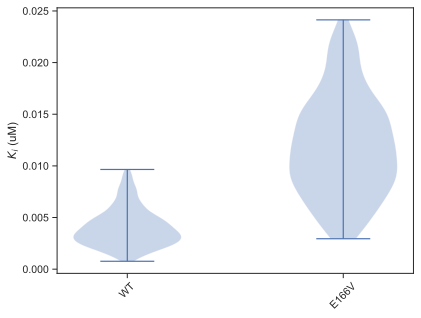

In [278]:
# violin plot with sample name labels
fig, ax = plt.subplots()
ax.violinplot(kis)
ax.set_xticks(np.arange(1, len(sample_name) + 1))
ax.set_xticklabels(sample_name, rotation=45)
ax.set_ylabel('$K_i$ (uM)')


## 10. Export to CSV in format people like

In [ ]:
#Summary CSV, showing data for each SAMPLE:
output_csv_name = 'inhibition_summary'

import csv
with open(output_csv_name+'_short.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'Ki_mean_filtered', 
                     'Ki_stdev_filtered', 
                     'enzyme'])
    #write data:
    for i, sample_name in enumerate(sample_names):
        row = [sample_name,
               sample_name,
               db_conn._json_dict['runs']['kinetics_0']['type'], 
               len(sample_K_i_replicates[i]), 
               sample_K_i[i], 
               sample_K_i_error[i], 
               enzyme_concentration_converted_units[i],
               ]
        writer.writerow(row)

In [ ]:
#Full CSV, showing data for each CHAMBER:
import csv
output_csv_name = 'inhibition'

with open(output_csv_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write header:
    writer.writerow(['id', 
                     'x,y',
                     'substrate_name', 
                     'assay_type', 
                     'replicates', 
                     'Ki', 
                     'Ki_mean_filtered', 
                     'Ki_stdev_filtered', 
                     'enzyme',])
    #write data for each chamber:
    for i, chamber_idx in enumerate(chamber_idxs):
        sample_name = chamber_names_dict[chamber_idx]
        #get index in sample_names:
        if sample_name in sample_names:
            sample_idx = list(sample_names).index(sample_name)
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    len(sample_K_i_replicates[sample_idx]), #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i'], #kcat
                    sample_K_i[sample_idx], #kcat_mean_filtered
                    sample_K_i_error[sample_idx], #kcat_stdev_filtered
                    enzyme_concentration_converted_units[i], #enzyme
                    ]
        else:
            row = [chamber_names_dict[chamber_idx], #id
                    chamber_idx, #x,y
                    sample_name, #substrate_name
                    db_conn._json_dict['runs']['kinetics_0']['type'], #assay_type
                    'NaN', #replicates
                    db_conn._json_dict['runs']['kinetics_0']['analyses']['K_i_raw']['chambers'][chamber_idx]['K_i'], #kcat
                    'NaN', #K_i_mean_filtered
                    'NaN', #K_i_stdev_filtered
                    enzyme_concentration_converted_units[i], #enzyme
            ]
        
        writer.writerow(row)